## On-Policy Monte Carlo Control

Dans ce notebook, nous allons implémenter l'une des deux stratégies majeures basées sur l'apprentissage d'une politique par interaction avec l'environnement, appelée *on-policy learning* (apprentissage sur politique).

L'agent va dérouler un épisode entier, du début à la fin, et sur la base de cette expérience, il va mettre à jour les q-values de chaque paire état-action $Q(s,a)$.

## Gérer les imports

In [2]:
import gym
from gym import spaces
import scipy.stats as stat
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from IPython import display

from bucket_env import BucketEnv3
from bucket_env import plot_stats, testing, rendering
%matplotlib inline

pygame 2.1.4.dev1 (SDL 2.26.0, Python 3.11.1)
Hello from the pygame community. https://www.pygame.org/contribute.html


objc[68232]: Class SDLApplication is implemented in both /opt/local/lib/libSDL2-2.0.0.dylib (0x1606907c0) and /opt/homebrew/Cellar/sdl2/2.26.1/lib/libSDL2-2.0.0.dylib (0x160cc0800). One of the two will be used. Which one is undefined.
objc[68232]: Class SDLAppDelegate is implemented in both /opt/local/lib/libSDL2-2.0.0.dylib (0x160690810) and /opt/homebrew/Cellar/sdl2/2.26.1/lib/libSDL2-2.0.0.dylib (0x160cc0850). One of the two will be used. Which one is undefined.
objc[68232]: Class SDLTranslatorResponder is implemented in both /opt/local/lib/libSDL2-2.0.0.dylib (0x160690888) and /opt/homebrew/Cellar/sdl2/2.26.1/lib/libSDL2-2.0.0.dylib (0x160cc08c8). One of the two will be used. Which one is undefined.
objc[68232]: Class SDLMessageBoxPresenter is implemented in both /opt/local/lib/libSDL2-2.0.0.dylib (0x1606908b0) and /opt/homebrew/Cellar/sdl2/2.26.1/lib/libSDL2-2.0.0.dylib (0x160cc08f0). One of the two will be used. Which one is undefined.
objc[68232]: Class SDL_cocoametalview is imp

## Initialiser l'environnement
Pour créer l'environnement, il faut simplement créer une instance de `BucketEnv3`

In [3]:
env = BucketEnv3()

## Definition de la table de valeurs $Q(s, a)$

#### Création de la table $Q(s, a)$
Cette table doit permettre de lier chaque état à une action.
Pour cela, on utilise la librairie `numpy` pour créer un tableau avec une forme (*shape*) correspondant à cette paire.
La forme attendu est donnée par un tuple.

Exemple
```python
>>> s = (2,2)
>>> np.zeros(s)
array([[ 0.,  0.],
       [ 0.,  0.]])
```


In [4]:
action_values = np.zeros((7,7,7,5))

## Définition d'une politique $\pi(s)$

#### Création de la politique $\pi(s)$
La politique indique l'action à prendre en fonction d'un état.

Cette politique étant $\epsilon-$greedy, elle est responsable de l'exploration de l'espace.
Elle devra donc parfois renvoyer une action aléatoire.
Pour cela, nous allons définir une fonction prenant en paramètre une état et un paramètre `epsilon` ayant comme valeur par défaut `0.2`, indiquant que 20% du temps, une action aléatoire sera prise.

La prise en compte d'epsilon se fera en la comparant avec une valeur prise aléatoirement, grâce à `np.random.random()`.
La décision aléatoire sera également prise aléatoirement parmi les 5 actions possibles, grâce à `np.random.choice(5)`.

Dans le cas où la décision est prise par rapport $Q(s,a)$, il faut choisir l'action qui maximise la probabilité de succès. Comme il peut y avoir plusieurs actions maximisant cette valeur, nous allons devoir casser les équivalences. Pour cela, nous allons utiliser `np.flatnonzero()` combiné à la condition de maximisation `a == a.max()`

In [5]:
def policy(state, epsilon=.2):
    if np.random.random() < epsilon:
        return np.random.choice(5)
    else:
        a = action_values[state]
        return np.random.choice(np.flatnonzero(a == a.max()))


#### Tester la politique avec l'état (0, 0, 0)

In [23]:
policy(env.reset())

0

## Implementation de l'algorithme

</br>

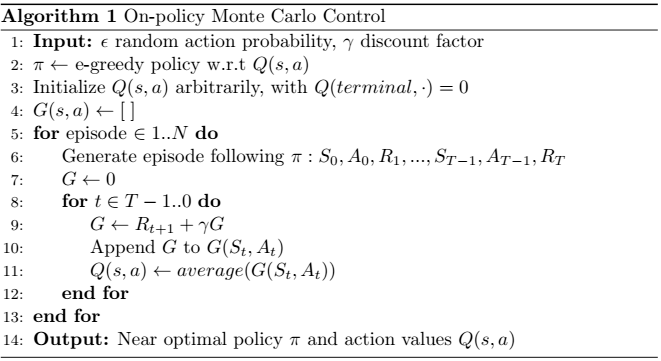
</br>
<div style="text-align:center">
    Adapted from Barto & Sutton: "Reinforcement Learning: An Introduction".
</div>



In [33]:
def on_policy_montecarlo(policy, action_values, episodes, epsilon=.01, gamma=.99):
    stats = {"Returns" : [] }
    for episode in tqdm(range(1,episodes + 1)):
        state = env.reset()
        done = False
        transitions = []
        sa_returns = {}
        ep_return = 0
        while not done:
            action = policy(state,epsilon)
            next_state, reward, done, _ = env.step(action)
            transitions.append([state,action,reward])
            state = next_state
            ep_return += reward
        stats["Returns"].append(ep_return)
        G = 0
        for state_t, action_t, reward_t in reversed(transitions):
            G = reward + gamma * G
            if not (state_t,action_t) in sa_returns:
                sa_returns[(state_t,action_t)] = []
            sa_returns[(state_t,action_t)].append(G)
            action_values[state_t][action_t] = np.mean(sa_returns[(state_t,action_t)])
    return stats



100%|██████████| 10000/10000 [00:01<00:00, 9533.29it/s]


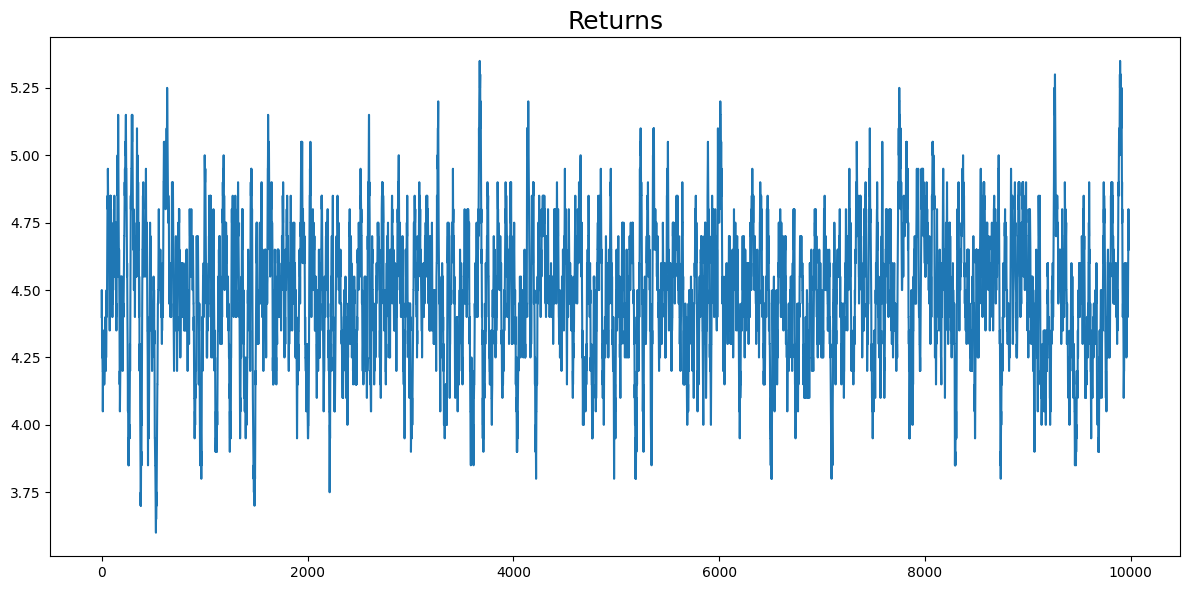

In [48]:
stats = on_policy_montecarlo(policy,action_values,episodes=10000,epsilon=0.2,gamma=0.99)
plot_stats(stats)

KeyboardInterrupt: 

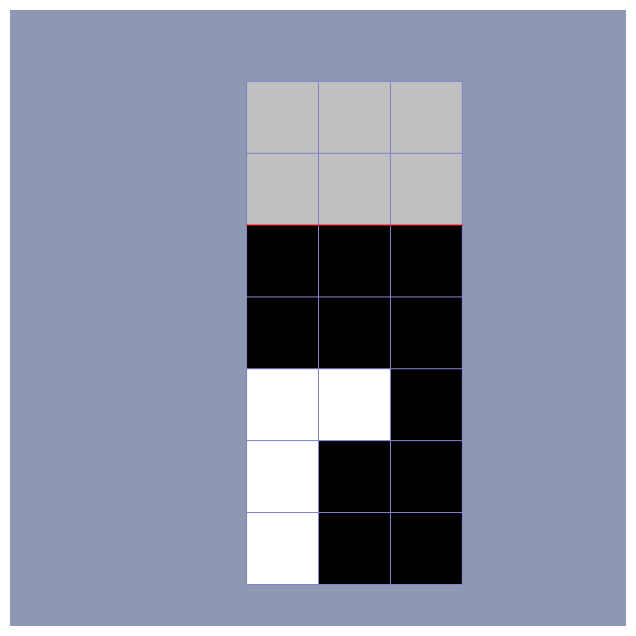

In [47]:
def policy2(state, epsilon=.2):
    a = action_values[state]
    return np.random.choice(np.flatnonzero(a == a.max()))
rendering(env,policy2,episodes=100)
